<a href="https://colab.research.google.com/github/aymuos/starship/blob/main/spark_rewrite/feats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
# Load only the first 10 records from the parquet file
df_first_10 = lazy_df.head(10).collect()

print(df_first_10)

shape: (10, 5)
┌─────┬─────────────────────────────────┬────────────────┬──────────┬──────────┐
│ ds  ┆ postman_id                      ┆ gps_time       ┆ lat      ┆ lng      │
│ --- ┆ ---                             ┆ ---            ┆ ---      ┆ ---      │
│ i64 ┆ str                             ┆ str            ┆ f64      ┆ f64      │
╞═════╪═════════════════════════════════╪════════════════╪══════════╪══════════╡
│ 321 ┆ 106f5ac22cfd1574b196d16fed62f9… ┆ 03-21 07:31:58 ┆ 3.9537e6 ┆ 3.0534e6 │
│ 321 ┆ 106f5ac22cfd1574b196d16fed62f9… ┆ 03-21 07:32:18 ┆ 3.9537e6 ┆ 3.0534e6 │
│ 321 ┆ 106f5ac22cfd1574b196d16fed62f9… ┆ 03-21 07:32:41 ┆ 3.9537e6 ┆ 3.0534e6 │
│ 321 ┆ 106f5ac22cfd1574b196d16fed62f9… ┆ 03-21 07:55:51 ┆ 3.9537e6 ┆ 3.0534e6 │
│ 321 ┆ 106f5ac22cfd1574b196d16fed62f9… ┆ 03-21 08:31:42 ┆ 3.9539e6 ┆ 3.0524e6 │
│ 321 ┆ 106f5ac22cfd1574b196d16fed62f9… ┆ 03-21 08:32:32 ┆ 3.9540e6 ┆ 3.0530e6 │
│ 321 ┆ 106f5ac22cfd1574b196d16fed62f9… ┆ 03-21 08:32:52 ┆ 3.9539e6 ┆ 3.0526e6 │
│ 321 ┆ 106f5

First, let's load the `shanghai_data.csv` file using Polars to ensure both datasets are handled consistently.

In [43]:
import polars as pl

shanghai_df = pl.read_csv("shanghai_data.csv")
shanghai_df = shanghai_df.with_row_index(name="order_index")

hangzhou_df = pl.read_csv("hangzhou_data.csv")
hangzhou_df = hangzhou_df.with_row_index(name="order_index")

chongqing_df = pl.read_csv("chongqing_data.csv")
chongqing_df = chongqing_df.with_row_index(name="order_index")

print(shanghai_df.head())

shape: (5, 16)
┌─────────────┬─────────────┬────────────┬────────────┬───┬──────────┬──────────┬─────┬────────────┐
│ order_index ┆ order_id    ┆ from_dipan ┆ delivery_u ┆ … ┆ sign_lng ┆ sign_lat ┆ ds  ┆ from_city_ │
│ ---         ┆ ---         ┆ _id        ┆ ser_id     ┆   ┆ ---      ┆ ---      ┆ --- ┆ en         │
│ u32         ┆ str         ┆ ---        ┆ ---        ┆   ┆ str      ┆ str      ┆ i64 ┆ ---        │
│             ┆             ┆ str        ┆ str        ┆   ┆          ┆          ┆     ┆ str        │
╞═════════════╪═════════════╪════════════╪════════════╪═══╪══════════╪══════════╪═════╪════════════╡
│ 0           ┆ 687227b4d0c ┆ 08331170e2 ┆ 18ff78d206 ┆ … ┆ null     ┆ null     ┆ 318 ┆ Shanghai   │
│             ┆ 733049b16cc ┆ 4742ba7a39 ┆ 9125937a84 ┆   ┆          ┆          ┆     ┆            │
│             ┆ d566db6e…   ┆ 38f5b34ff2 ┆ 7fb701a9db ┆   ┆          ┆          ┆     ┆            │
│             ┆             ┆ …          ┆ …          ┆   ┆          ┆      

In [6]:
import polars as pl

# Re-initialize lazy_df from the parquet file
lazy_df = pl.scan_parquet("/content/drive/MyDrive/ml/trajectory.parquet")

# Load shanghai_data.csv and take only the first 30 rows
shanghai_df_subset = pl.read_csv("shanghai_data.csv").head(30)
shanghai_df_subset.write_csv("shanghai_top30.csv")
print("Exported shanghai_top30.csv")

# Perform an inner join with the subset of shanghai_df, using streaming for collection
joined_df_subset = lazy_df.join(
    shanghai_df_subset.lazy(), # Convert subset to a LazyFrame
    left_on="postman_id",
    right_on="delivery_user_id",
    how="inner"
).collect(engine="streaming")

print(joined_df_subset.head(12))

Exported shanghai_top30.csv
shape: (12, 19)
┌─────┬──────────────┬──────────┬──────────────┬───┬──────────┬──────────┬──────────┬──────────────┐
│ ds  ┆ postman_id   ┆ gps_time ┆ lat          ┆ … ┆ sign_lng ┆ sign_lat ┆ ds_right ┆ from_city_en │
│ --- ┆ ---          ┆ ---      ┆ ---          ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---          │
│ i64 ┆ str          ┆ str      ┆ f64          ┆   ┆ str      ┆ str      ┆ i64      ┆ str          │
╞═════╪══════════════╪══════════╪══════════════╪═══╪══════════╪══════════╪══════════╪══════════════╡
│ 328 ┆ dd648d4143da ┆ 03-28    ┆ 988917.63683 ┆ … ┆ null     ┆ null     ┆ 318      ┆ Shanghai     │
│     ┆ a61906cdb8c2 ┆ 07:31:43 ┆ 8            ┆   ┆          ┆          ┆          ┆              │
│     ┆ 83aedb…      ┆          ┆              ┆   ┆          ┆          ┆          ┆              │
│ 328 ┆ dd648d4143da ┆ 03-28    ┆ 988917.63683 ┆ … ┆ null     ┆ null     ┆ 318      ┆ Shanghai     │
│     ┆ a61906cdb8c2 ┆ 07:31:43 ┆ 8            

In [11]:
# Export joined_df_subset to a CSV file
joined_df_subset.write_csv("trajectory_top30.csv")
print("Exported joined data to trajectory_top30.csv")

Exported joined data to trajectory_top30.csv


Now, we will join `shanghai_df` with the `lazy_df` (which is scanned from `trajectory.parquet`) where `delivery_user_id` from `shanghai_df` matches `postman_id` from `lazy_df`. We'll use an inner join to get only the matching records.

In [30]:
shanghai_df.columns

['order_index',
 'order_id',
 'from_dipan_id',
 'delivery_user_id',
 'poi_lng',
 'poi_lat',
 'aoi_id',
 'typecode',
 'receipt_time',
 'receipt_lng',
 'receipt_lat',
 'sign_time',
 'sign_lng',
 'sign_lat',
 'ds',
 'from_city_en']

In [45]:
# add eta columns to shanghai
shanghai_df = shanghai_df.with_columns(
    (pl.col("sign_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False) -
     pl.col("receipt_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False))
    .dt.total_minutes()
    .alias("horizon_ETA")
)


hangzhou_df = hangzhou_df.with_columns(
    (pl.col("sign_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False) -
     pl.col("receipt_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False))
    .dt.total_minutes()
    .alias("horizon_ETA")
)

chongqing_df = chongqing_df.with_columns(
    (pl.col("sign_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False) -
     pl.col("receipt_time").str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False))
    .dt.total_minutes()
    .alias("horizon_ETA")
)

print(hangzhou_df.head())

shape: (5, 17)
┌────────────┬────────────┬────────────┬────────────┬───┬──────────┬─────┬────────────┬────────────┐
│ order_inde ┆ order_id   ┆ from_dipan ┆ delivery_u ┆ … ┆ sign_lat ┆ ds  ┆ from_city_ ┆ horizon_ET │
│ x          ┆ ---        ┆ _id        ┆ ser_id     ┆   ┆ ---      ┆ --- ┆ en         ┆ A          │
│ ---        ┆ str        ┆ ---        ┆ ---        ┆   ┆ str      ┆ i64 ┆ ---        ┆ ---        │
│ u32        ┆            ┆ str        ┆ str        ┆   ┆          ┆     ┆ str        ┆ i64        │
╞════════════╪════════════╪════════════╪════════════╪═══╪══════════╪═════╪════════════╪════════════╡
│ 0          ┆ 2b83e2ba16 ┆ 4fe9625027 ┆ 1d00e6f230 ┆ … ┆ null     ┆ 318 ┆ Hangzhou   ┆ 3192       │
│            ┆ 714fee3576 ┆ 0c2e17a280 ┆ 8aad233f01 ┆   ┆          ┆     ┆            ┆            │
│            ┆ 94964d0e7e ┆ 16a5fba4bc ┆ 79aac63aa2 ┆   ┆          ┆     ┆            ┆            │
│            ┆ …          ┆ …          ┆ …          ┆   ┆          ┆     ┆  

In [46]:
negative_eta_records = shanghai_df.filter(
    (pl.col("horizon_ETA").is_not_null()) & (pl.col("horizon_ETA") < 0)
)
print(f"size of sample_records negative:{negative_eta_records.count()}")
print("Sample records with negative Horizon ETA:")
print(negative_eta_records.select(['order_index','receipt_time', 'sign_time', 'horizon_ETA']).head(10))


negative_eta_records_hz = hangzhou_df.filter(
    (pl.col("horizon_ETA").is_not_null()) & (pl.col("horizon_ETA") < 0)
)
print(f"size of sample_records negative in Hz:{negative_eta_records_hz.count()}")
print("Sample records with negative Horizon ETA in hz :")
print(negative_eta_records_hz.select(['order_index','receipt_time', 'sign_time', 'horizon_ETA']).head(10))


print("-----------------------------")

negative_eta_records_cq = chongqing_df.filter(
    (pl.col("horizon_ETA").is_not_null()) & (pl.col("horizon_ETA") < 0)
)
print(f"size of sample_records negative in cq:{negative_eta_records_cq.count()}")
print("Sample records with negative Horizon ETA in cq:")
print(negative_eta_records_cq.select(['order_index','receipt_time', 'sign_time', 'horizon_ETA']).head(10))

size of sample_records negative:shape: (1, 17)
┌─────────────┬──────────┬─────────────┬────────────┬───┬──────────┬─────┬────────────┬────────────┐
│ order_index ┆ order_id ┆ from_dipan_ ┆ delivery_u ┆ … ┆ sign_lat ┆ ds  ┆ from_city_ ┆ horizon_ET │
│ ---         ┆ ---      ┆ id          ┆ ser_id     ┆   ┆ ---      ┆ --- ┆ en         ┆ A          │
│ u32         ┆ u32      ┆ ---         ┆ ---        ┆   ┆ u32      ┆ u32 ┆ ---        ┆ ---        │
│             ┆          ┆ u32         ┆ u32        ┆   ┆          ┆     ┆ u32        ┆ u32        │
╞═════════════╪══════════╪═════════════╪════════════╪═══╪══════════╪═════╪════════════╪════════════╡
│ 16          ┆ 16       ┆ 16          ┆ 16         ┆ … ┆ 0        ┆ 16  ┆ 16         ┆ 16         │
└─────────────┴──────────┴─────────────┴────────────┴───┴──────────┴─────┴────────────┴────────────┘
Sample records with negative Horizon ETA:
shape: (10, 4)
┌─────────────┬─────────────────────┬─────────────────────┬─────────────┐
│ order_index 

In [47]:
print(f"Number of records with negative Horizon ETA Shanghai: {negative_eta_records.height}")
print(f"Total number of records in shanghai_df: {shanghai_df.height}")

print(f"Number of records with negative Horizon ETA Hangzhou: {negative_eta_records_hz.height}")
print(f"Total number of records in hangzhou_df: {hangzhou_df.height}")

print(f"Number of records with negative Horizon ETA: {negative_eta_records_cq.height}")
print(f"Total number of records in chongquing_df: {chongqing_df.height}")

Number of records with negative Horizon ETA Shanghai: 16
Total number of records in shanghai_df: 165583
Number of records with negative Horizon ETA Hangzhou: 25
Total number of records in hangzhou_df: 103034
Number of records with negative Horizon ETA: 4
Total number of records in chongquing_df: 99783


In [48]:
# Drop records where horizon_ETA is negative (or null if preferred, but for this task, only negative)
shanghai_df_filtered = shanghai_df.filter(
    (pl.col("horizon_ETA").is_not_null()) & (pl.col("horizon_ETA") >= 0)
)

# Sort the filtered DataFrame by horizon_ETA from smallest to largest
shanghai_df_sorted_filtered = shanghai_df_filtered.sort("horizon_ETA")

# Get and print the new minimum and maximum horizon_ETA
min_eta_after_drop = shanghai_df_sorted_filtered["horizon_ETA"].min()
max_eta_after_drop = shanghai_df_sorted_filtered["horizon_ETA"].max()

print(f"Minimum Horizon ETA (after dropping negatives): {min_eta_after_drop} minutes")
print(f"Maximum Horizon ETA (after dropping negatives): {max_eta_after_drop/3600} days")

print("\nFirst 5 rows of shanghai_df after dropping negatives and sorting:")
print(shanghai_df_sorted_filtered.head())



#############################################
# Drop records where horizon_ETA is negative (or null if preferred, but for this task, only negative)
hangzhou_df_filtered = hangzhou_df.filter(
    (pl.col("horizon_ETA").is_not_null()) & (pl.col("horizon_ETA") >= 0)
)

# Sort the filtered DataFrame by horizon_ETA from smallest to largest
hangzhou_df_sorted_filtered = hangzhou_df_filtered.sort("horizon_ETA")

# Get and print the new minimum and maximum horizon_ETA
min_eta_after_drop_hz = hangzhou_df_sorted_filtered["horizon_ETA"].min()
max_eta_after_drop_hz = hangzhou_df_sorted_filtered["horizon_ETA"].max()

print(f"Minimum Horizon ETA (after dropping negatives) Hangzhou: {min_eta_after_drop_hz} minutes")
print(f"Maximum Horizon ETA (after dropping negatives) Hangzhou: {max_eta_after_drop_hz/3600} days")

print("\nFirst 5 rows of hangzhou_df after dropping negatives and sorting:")
print(hangzhou_df_sorted_filtered.head())

#############################################
# Drop records where horizon_ETA is negative (or null if preferred, but for this task, only negative)
chongquing_df_filtered = chongquing_df.filter(
    (pl.col("horizon_ETA").is_not_null()) & (pl.col("horizon_ETA") >= 0)
)

# Sort the filtered DataFrame by horizon_ETA from smallest to largest
chongquing_df_sorted_filtered = chongquing_df_filtered.sort("horizon_ETA")

# Get and print the new minimum and maximum horizon_ETA
min_eta_after_drop_cq = chongquing_df_sorted_filtered["horizon_ETA"].min()
max_eta_after_drop_cq = chongquing_df_sorted_filtered["horizon_ETA"].max()

print(f"Minimum Horizon ETA (after dropping negatives) CQ: {min_eta_after_drop_cq} minutes")
print(f"Maximum Horizon ETA (after dropping negatives) CQ: {max_eta_after_drop_cq/3600} days")

print("\nFirst 5 rows of chongquing_df after dropping negatives and sorting:")
print(chongquing_df_sorted_filtered.head())


Minimum Horizon ETA (after dropping negatives): 0 minutes
Maximum Horizon ETA (after dropping negatives): 7.6819444444444445 days

First 5 rows of shanghai_df after dropping negatives and sorting:
shape: (5, 17)
┌────────────┬────────────┬────────────┬────────────┬───┬──────────┬─────┬────────────┬────────────┐
│ order_inde ┆ order_id   ┆ from_dipan ┆ delivery_u ┆ … ┆ sign_lat ┆ ds  ┆ from_city_ ┆ horizon_ET │
│ x          ┆ ---        ┆ _id        ┆ ser_id     ┆   ┆ ---      ┆ --- ┆ en         ┆ A          │
│ ---        ┆ str        ┆ ---        ┆ ---        ┆   ┆ str      ┆ i64 ┆ ---        ┆ ---        │
│ u32        ┆            ┆ str        ┆ str        ┆   ┆          ┆     ┆ str        ┆ i64        │
╞════════════╪════════════╪════════════╪════════════╪═══╪══════════╪═════╪════════════╪════════════╡
│ 420        ┆ c05d6dd04a ┆ 48a0f191bf ┆ 588e8c577e ┆ … ┆ null     ┆ 318 ┆ Shanghai   ┆ 0          │
│            ┆ 915f944e16 ┆ 86ef383ffc ┆ 2fb947b283 ┆   ┆          ┆     ┆       

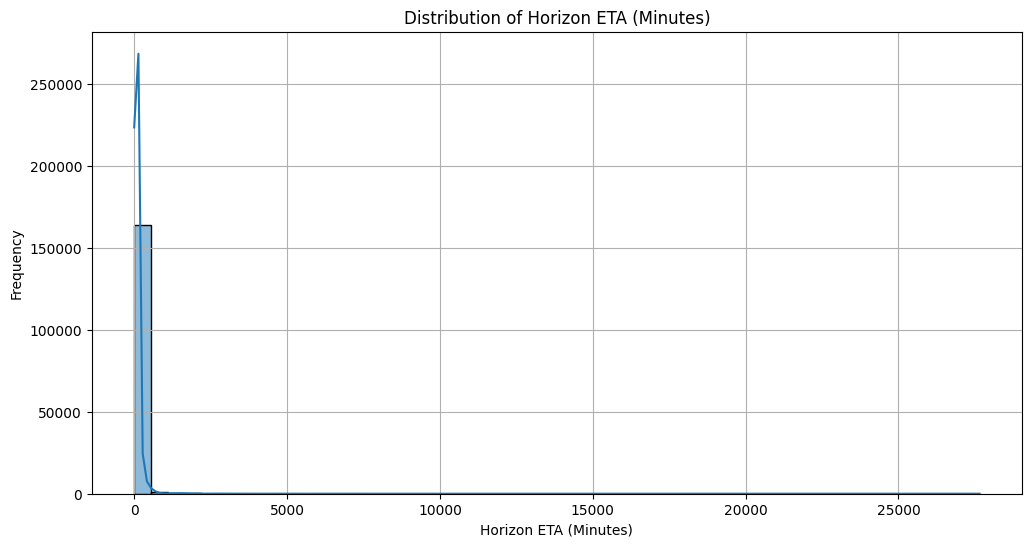

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Polars DataFrame to Pandas DataFrame for seaborn plotting
pandas_df_filtered = shanghai_df_filtered.to_pandas()

# Create the distribution plot
plt.figure(figsize=(12, 6))
sns.histplot(pandas_df_filtered['horizon_ETA'], bins=50, kde=True)
plt.title('Distribution of Horizon ETA (Minutes)')
plt.xlabel('Horizon ETA (Minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [39]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Ensure shanghai_df_filtered is converted to pandas for easier access for numpy/scipy
pandas_df_filtered = shanghai_df_filtered.to_pandas()

# Convert horizon_ETA from minutes to hours
eta_hours = pandas_df_filtered['horizon_ETA'] / 60

# 2. Find natural modes/clusters
density = gaussian_kde(eta_hours)
xs = np.linspace(0, eta_hours.max(), 1000)
density_values = density(xs)

# Find peaks (local maxima) - height parameter might need adjustment based on data
peaks, _ = find_peaks(density_values, height=0.001) # Adjust height as needed to find relevant peaks
peak_locations = xs[peaks]

print(f"Natural clusters (peaks) at: {peak_locations} hours")

# 3. Calculate percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(eta_hours, p):.2f} hours")

Natural clusters (peaks) at: [0.92275609] hours
10th percentile: 0.42 hours
25th percentile: 0.72 hours
50th percentile: 1.23 hours
75th percentile: 2.02 hours
90th percentile: 3.10 hours
95th percentile: 3.95 hours
99th percentile: 9.37 hours


- ✓ This is a LAST-MILE urban delivery dataset
- ✓ 90% of deliveries complete within 3 hours
- ✓ 95% complete within 4 hours
- ✓ Typical delivery: ~1 hour (peak at 0.92h, median 1.23h)

- ✗ NOT a long-distance logistics dataset
- ✗ The 7.68 day maximum is likely outliers/errors
- ✗ "Multi-day horizon" is only 1-5% of your data

In [ ]:

# Ensure hangzhou_df_filtered is converted to pandas for easier access for numpy/scipy
pandas_df_filtered_hz = hangzhou_df_filtered.to_pandas()

# Convert horizon_ETA from minutes to hours
eta_hours = pandas_df_filtered_hz['horizon_ETA'] / 60

# 2. Find natural modes/clusters
density = gaussian_kde(eta_hours)
xs = np.linspace(0, eta_hours.max(), 1000)
density_values = density(xs)

# Find peaks (local maxima) - height parameter might need adjustment based on data
peaks, _ = find_peaks(density_values, height=0.001) # Adjust height as needed to find relevant peaks
peak_locations = xs[peaks]

print(f"HZ : Natural clusters (peaks) at: {peak_locations} hours")

# 3. Calculate percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(eta_hours, p):.2f} hours")

In [ ]:


# Ensure shanghai_df_filtered is converted to pandas for easier access for numpy/scipy
pandas_df_filtered = shanghai_df_filtered.to_pandas()

# Convert horizon_ETA from minutes to hours
eta_hours = pandas_df_filtered['horizon_ETA'] / 60

# 2. Find natural modes/clusters
density = gaussian_kde(eta_hours)
xs = np.linspace(0, eta_hours.max(), 1000)
density_values = density(xs)

# Find peaks (local maxima) - height parameter might need adjustment based on data
peaks, _ = find_peaks(density_values, height=0.001) # Adjust height as needed to find relevant peaks
peak_locations = xs[peaks]

print(f"Natural clusters (peaks) at: {peak_locations} hours")

# 3. Calculate percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(eta_hours, p):.2f} hours")

# Task
Create a distribution plot (histogram with Kernel Density Estimate) for `horizon_ETA` in the filtered Hangzhou data (`hangzhou_df_filtered`), showing frequency counts. Convert the Polars DataFrame to Pandas for plotting with Seaborn.

## Visualize Shanghai ETA Distribution

### Subtask:
Create a distribution plot (histogram with Kernel Density Estimate) for `horizon_ETA` in the filtered Shanghai data (`shanghai_df_filtered`), showing frequency counts. Convert the Polars DataFrame to Pandas for plotting with Seaborn.


**Reasoning**:
The previous code already generated the requested plot for `shanghai_df_filtered`. I will modify the existing code to align with the new variable name `pandas_df_filtered_shanghai` and update the plot title as specified in the instructions to avoid regenerating the same plot without the requested changes.

